<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/10_time_series_forecasting_with_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-05 19:56:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-03-05 19:56:47 (5.65 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples.

A smaller number of samples is something you'll often run into  with time series data problems. 

> 🔑 **Note:** The **seasonality** of time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.



In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


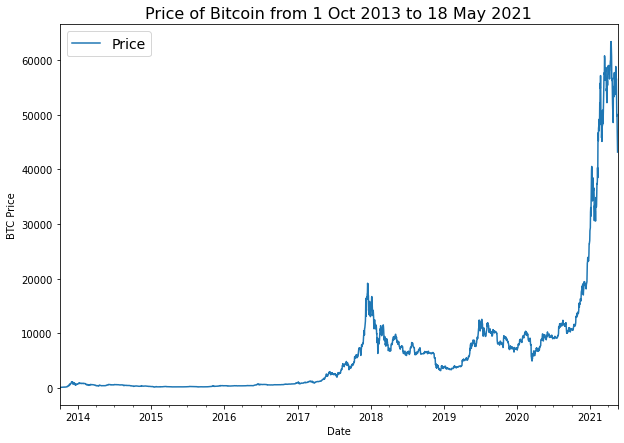

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [6]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

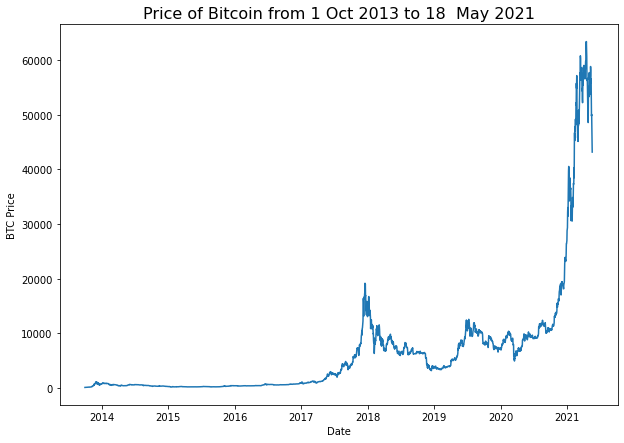

In [7]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps,
         btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18  May 2021", fontsize=16)
plt.xlabel("Date");


## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [8]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [9]:
# Wrong way to make train/test sets for timeseries data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

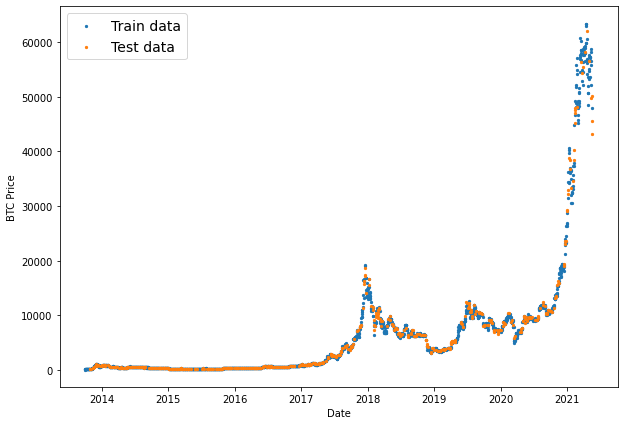

In [10]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)


In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

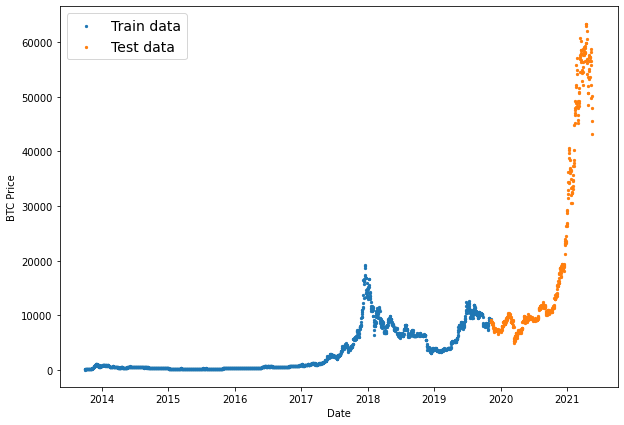

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

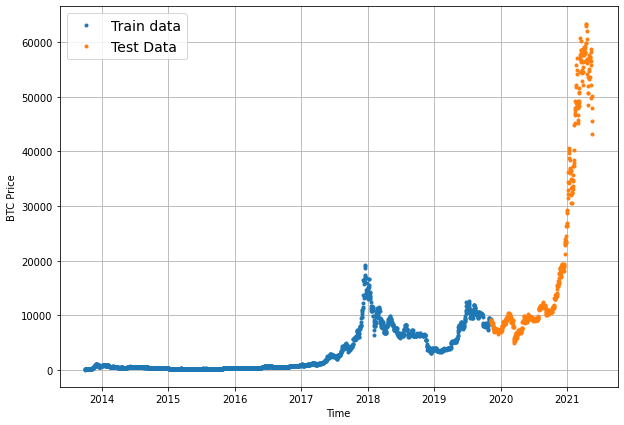

In [14]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)


## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

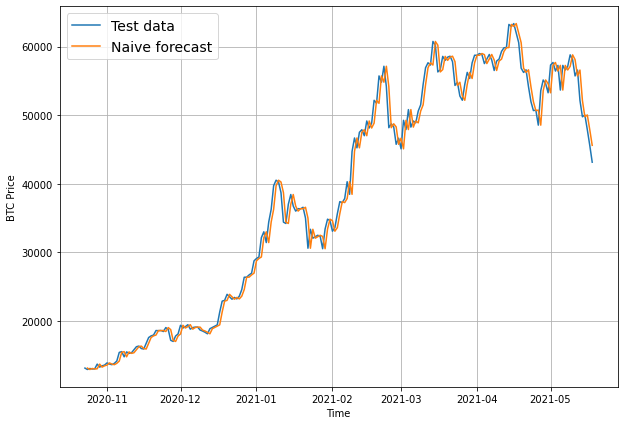

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

> ⚒️ **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. An have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up?

from IPython.core.magic import error
## Evaluating a time series model

Let's take into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that mean we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RSME - root mean suare error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
+ MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than a MAE of 100.

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
import tensorflow as tf

In [18]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates the mean absolute scaled error (MASE) between true and predicted values.

  The MASE measures the relative performance of a forecasting model compared to a naive (naïve2) forecast.
  The MASE is a scaling factor that scales the mean absolute error (MAE) of the forecast to account for the scale
  of the data and the forecast horizon. A MASE of 1 indicates that the forecasting model performs as well as a
  naive forecast, while a MASE < 1 indicates that the model outperforms the naive forecast.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A scalar value representing the MASE between y_true and y_pred.
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae / mae_naive_no_season

In [19]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [20]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [22]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [23]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [24]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
len(y_train)

2229

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use past week of Bitcoin data to make the prediction


In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
    Given a data matrix 'x', return a pair of matrices containing labelled and windowed segments of the data.

    Parameters:
        - x (ndarray): A 2-dimensional matrix of shape (T, D), where T is the number of timesteps and
          D is the number of dimensions.
        - horizon (int): The number of timesteps to include in the window.
        
    Returns:
        - A tuple containing two 2-dimensional matrices of shape (T - horizon, horizon) and (T - horizon, 1),
          respectively. The first matrix contains the windowed segments of the input data, and the second matrix
          contains the labels that correspond to each window.
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 5, 6],
[1, 2, 3, 5, 6, 7],
[2, 3, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [30]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Creates windowed data from a target time series.

  Parameters:
      - x (ndarray): A 1-dimensional array containing the target time series.
      - window_size (int): The size of the window to use to create the data (default: WINDOW_SIZE).
      - horizon (int): The number of timesteps into the future to predict (default: HORIZON).

  Returns:
      - A tuple containing two 2-dimensional arrays of shape (N, window_size) and (N, horizon),
        respectively. The first array contains the windowed segments of the input data, and the
        second array contains the labels that correspond to each window.

  Example usage:
  ```python
  # Load some example data
  target_series = np.loadtxt('target_series.txt')

  # Create windowed data with a window size of 30 and a horizon of 1
  X, y = make_windows(target_series, window_size=30, horizon=1)
  ```
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (a time series) with 2D araay of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [33]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.

  Parameters:
       - windows (ndarray): A 2-dimensional matrix of shape (N, W), where N is the number of windows
        and W is the window size.
      - labels (ndarray): A 2-dimensional matrix of shape (N, H), where N is the number of windows
        and H is the horizon (i.e. the number of timesteps to predict into the future).
      - test_split (float): The proportion of data to allocate for the test split. Defaults to 0.2.

  Returns:
      - A tuple containing four 2-dimensional matrices: (train_windows, test_windows, train_labels, test_labels).
        The training windows and labels are the first two elements of the tuple and represent the training split of
        the input data, while the test windows and labels are the last two elements of the tuple and represent the
        test split of the input data.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [38]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [41]:
import os

# Create a function to implement a modelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  """
  Creates a Keras callback to save the best version of a trained model during training.

  Args:
      model_name (str): A string with the name of the model. This will be used as the prefix of the checkpoint file.
      save_path (str): A string with the directory path where the checkpoint file will be saved. Defaults to "model_experiments".

  Returns:
      A Keras `ModelCheckpoint` callback instance with the specified settings.
  """
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)


## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* *Hyperparameters* = values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own


In [43]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1_history = model_1.fit(train_windows, train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 30s - loss: 3247.8237 - mae: 3247.8237 - mse: 21819680.0000

18/18 [==============================] - 4s 105ms/step - loss: 1189.2716 - mae: 1189.2716 - mse: 5345527.0000 - val_loss: 3291.5518 - val_mae: 3291.5518 - val_mse: 25103850.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 344.2067 - mae: 344.2067 - mse: 518796.0938 

18/18 [==============================] - 1s 65ms/step - loss: 329.5973 - mae: 329.5973 - mse: 487761.3125 - val_loss: 1320.5126 - val_mae: 1320.5126 - val_mse: 5728681.0000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 239.9896 - mae: 239.9896 - mse: 274160.5312

18/18 [==============================] - 1s 52ms/step - loss: 237.9724 - mae: 237.9724 - mse: 272649.8125 - val_loss: 1232.2482 - val_mae: 1232.2482 - val_mse: 4914648.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 286.6248 - mae: 286.6248 - mse: 446256.6875

18/18 [==============================] - 1s 42ms/step - loss: 219.4880 - mae: 219.4880 - mse: 250847.3594 - val_loss: 1177.4250 - val_mae: 1177.4250 - val_mse: 4484575.0000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 213.0901 - mae: 213.0901 - mse: 172145.5469

18/18 [==============================] - 1s 40ms/step - loss: 209.7873 - mae: 209.7873 - mse: 231072.8594 - val_loss: 1138.7471 - val_mae: 1138.7471 - val_mse: 4151524.2500
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 152.8224 - mae: 152.8224 - mse: 87454.2969

18/18 [==============================] - 1s 40ms/step - loss: 202.7322 - mae: 202.7322 - mse: 211770.8750 - val_loss: 1082.2885 - val_mae: 1082.2885 - val_mse: 3822749.2500
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 239.4568 - mae: 239.4568 - mse: 424662.4062

18/18 [==============================] - 1s 40ms/step - loss: 189.0273 - mae: 189.0273 - mse: 191126.4844 - val_loss: 1038.7316 - val_mae: 1038.7316 - val_mse: 3477270.2500
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 157.5296 - mae: 157.5296 - mse: 100592.9219

18/18 [==============================] - 1s 41ms/step - loss: 179.7745 - mae: 179.7745 - mse: 176449.0469 - val_loss: 989.3378 - val_mae: 989.3378 - val_mse: 3256246.7500
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 183.5338 - mae: 183.5338 - mse: 178606.7500

18/18 [==============================] - 2s 107ms/step - loss: 179.5905 - mae: 179.5905 - mse: 170815.6719 - val_loss: 959.8507 - val_mae: 959.8507 - val_mse: 3037437.0000
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 167.9001 - mae: 167.9001 - mse: 147322.5781

18/18 [==============================] - 1s 86ms/step - loss: 174.2341 - mae: 174.2341 - mse: 164280.0312 - val_loss: 928.7177 - val_mae: 928.7177 - val_mse: 2853403.0000
Epoch 11/100
18/18 [==============================] - 0s 4ms/step - loss: 170.1767 - mae: 170.1767 - mse: 152621.5312 - val_loss: 974.9651 - val_mae: 974.9651 - val_mse: 2859423.2500
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 164.2447 - mae: 164.2447 - mse: 145093.9219 - val_loss: 951.5860 - val_mae: 951.5860 - val_mse: 2720296.5000
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 160.7574 - mae: 160.7574 - mse: 141481.5469 - val_loss: 934.5651 - val_mae: 934.5651 - val_mse: 2614790.7500
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 154.6970 - mae: 154.6970 - mse: 130922.8047 - val_loss: 972.2634 - val_mae: 972.2634 - val_mse: 2692806.2500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 173.8768 - mae: 173.8768 - 

18/18 [==============================] - 1s 39ms/step - loss: 153.1106 - mae: 153.1106 - mse: 129959.7969 - val_loss: 849.6540 - val_mae: 849.6540 - val_mse: 2266861.0000
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 146.2889 - mae: 146.2889 - mse: 118630.2500 - val_loss: 872.3514 - val_mae: 872.3514 - val_mse: 2288473.7500
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 144.3301 - mae: 144.3301 - mse: 114945.6797 - val_loss: 858.4627 - val_mae: 858.4627 - val_mse: 2214719.5000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 162.9285 - mae: 162.9285 - mse: 128664.1406

18/18 [==============================] - 1s 39ms/step - loss: 144.4832 - mae: 144.4832 - mse: 114843.8203 - val_loss: 799.5633 - val_mae: 799.5633 - val_mse: 2014547.6250
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 85.1799 - mae: 85.1799 - mse: 38999.9844

18/18 [==============================] - 1s 59ms/step - loss: 137.7170 - mae: 137.7170 - mse: 107054.2891 - val_loss: 772.8139 - val_mae: 772.8139 - val_mse: 1912122.3750
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 134.8163 - mae: 134.8163 - mse: 104243.0703

18/18 [==============================] - 1s 62ms/step - loss: 134.9305 - mae: 134.9305 - mse: 103524.6094 - val_loss: 740.8766 - val_mae: 740.8766 - val_mse: 1872943.3750
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 137.1516 - mae: 137.1516 - mse: 102117.2031

18/18 [==============================] - 1s 61ms/step - loss: 137.9967 - mae: 137.9967 - mse: 106843.7344 - val_loss: 723.0039 - val_mae: 723.0039 - val_mse: 1754063.7500
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 131.9548 - mae: 131.9548 - mse: 98771.0234 - val_loss: 730.4868 - val_mae: 730.4868 - val_mse: 1727950.3750
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 127.9728 - mae: 127.9728 - mse: 75363.7656

18/18 [==============================] - 1s 43ms/step - loss: 134.1638 - mae: 134.1638 - mse: 99419.8906 - val_loss: 720.5453 - val_mae: 720.5453 - val_mse: 1677637.5000
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 136.6626 - mae: 136.6626 - mse: 83576.3984

18/18 [==============================] - 1s 40ms/step - loss: 127.3959 - mae: 127.3959 - mse: 92576.2422 - val_loss: 691.3855 - val_mae: 691.3855 - val_mse: 1649016.0000
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 131.9348 - mae: 131.9348 - mse: 67696.3203

18/18 [==============================] - 1s 41ms/step - loss: 127.8351 - mae: 127.8351 - mse: 90235.8906 - val_loss: 677.1636 - val_mae: 677.1636 - val_mse: 1546597.0000
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 119.4765 - mae: 119.4765 - mse: 66439.7109

18/18 [==============================] - 1s 42ms/step - loss: 123.2853 - mae: 123.2853 - mse: 87655.1875 - val_loss: 663.9356 - val_mae: 663.9356 - val_mse: 1515505.7500
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 121.4927 - mae: 121.4927 - mse: 86740.0469 - val_loss: 675.9123 - val_mae: 675.9123 - val_mse: 1574355.6250
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 119.7441 - mae: 119.7441 - mse: 70968.2266

18/18 [==============================] - 1s 40ms/step - loss: 120.5325 - mae: 120.5325 - mse: 83652.5234 - val_loss: 648.8304 - val_mae: 648.8304 - val_mse: 1441671.1250
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 114.1638 - mae: 114.1638 - mse: 93143.6953

18/18 [==============================] - 1s 41ms/step - loss: 119.2451 - mae: 119.2451 - mse: 82298.8516 - val_loss: 648.7433 - val_mae: 648.7433 - val_mse: 1428901.1250
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 134.4949 - mae: 134.4949 - mse: 94308.1719

18/18 [==============================] - 1s 41ms/step - loss: 127.0114 - mae: 127.0114 - mse: 87061.2031 - val_loss: 634.8497 - val_mae: 634.8497 - val_mse: 1406284.3750
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 116.3137 - mae: 116.3137 - mse: 79484.0469 - val_loss: 647.0029 - val_mae: 647.0029 - val_mse: 1408816.2500
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 115.2035 - mae: 115.2035 - mse: 78653.4297

18/18 [==============================] - 1s 40ms/step - loss: 116.1040 - mae: 116.1040 - mse: 81316.6250 - val_loss: 626.9219 - val_mae: 626.9219 - val_mse: 1360852.7500
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 115.6004 - mae: 115.6004 - mse: 79329.6797 - val_loss: 677.5261 - val_mae: 677.5261 - val_mse: 1473582.2500
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 142.1562 - mae: 142.1562 - mse: 122117.8359

18/18 [==============================] - 1s 38ms/step - loss: 117.1043 - mae: 117.1043 - mse: 81120.2266 - val_loss: 623.2674 - val_mae: 623.2674 - val_mse: 1359747.6250
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5001 - mae: 113.5001 - mse: 78291.5391 - val_loss: 647.9254 - val_mae: 647.9254 - val_mse: 1429863.3750
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 116.8628 - mae: 116.8628 - mse: 80136.2734 - val_loss: 632.9235 - val_mae: 632.9235 - val_mse: 1381661.5000
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 138.3682 - mae: 138.3682 - mse: 129391.6484

18/18 [==============================] - 1s 39ms/step - loss: 116.2475 - mae: 116.2475 - mse: 79985.0391 - val_loss: 614.7488 - val_mae: 614.7488 - val_mse: 1309995.0000
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 103.4757 - mae: 103.4757 - mse: 64927.0742

18/18 [==============================] - 1s 40ms/step - loss: 114.5621 - mae: 114.5621 - mse: 77988.8359 - val_loss: 604.6984 - val_mae: 604.6984 - val_mse: 1296567.2500
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 128.0358 - mae: 128.0358 - mse: 117285.5938

18/18 [==============================] - 1s 41ms/step - loss: 112.7246 - mae: 112.7246 - mse: 77368.8359 - val_loss: 602.3508 - val_mae: 602.3508 - val_mse: 1278856.8750
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6125 - mae: 110.6125 - mse: 73848.6875 - val_loss: 602.7994 - val_mae: 602.7994 - val_mse: 1287841.0000
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 107.4068 - mae: 107.4068 - mse: 55112.5078

18/18 [==============================] - 1s 39ms/step - loss: 110.8409 - mae: 110.8409 - mse: 73469.5312 - val_loss: 601.7784 - val_mae: 601.7784 - val_mse: 1271741.1250
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 115.5128 - mae: 115.5128 - mse: 78754.9453 - val_loss: 706.2006 - val_mae: 706.2006 - val_mse: 1514794.2500
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7823 - mae: 115.7823 - mse: 73640.9531 - val_loss: 670.3644 - val_mae: 670.3644 - val_mse: 1457020.7500
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 114.7140 - mae: 114.7140 - mse: 75276.0938 - val_loss: 613.8134 - val_mae: 613.8134 - val_mse: 1287914.2500
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 87.4023 - mae: 87.4023 - mse: 36244.6406

18/18 [==============================] - 1s 75ms/step - loss: 114.5516 - mae: 114.5516 - mse: 74126.4453 - val_loss: 591.5181 - val_mae: 591.5181 - val_mse: 1253106.6250
Epoch 46/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4154 - mae: 111.4154 - mse: 72565.8281 - val_loss: 604.7859 - val_mae: 604.7859 - val_mse: 1265848.1250
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 110.9716 - mae: 110.9716 - mse: 73745.1797 - val_loss: 625.8583 - val_mae: 625.8583 - val_mse: 1305248.2500
Epoch 48/100
15/18 [========================>.....] - ETA: 0s - loss: 109.1641 - mae: 109.1641 - mse: 75978.2188

18/18 [==============================] - 1s 63ms/step - loss: 108.6730 - mae: 108.6730 - mse: 72008.5312 - val_loss: 588.2798 - val_mae: 588.2798 - val_mse: 1230872.5000
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4833 - mae: 111.4833 - mse: 74154.3125 - val_loss: 691.1303 - val_mae: 691.1303 - val_mse: 1455092.1250
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 117.5397 - mae: 117.5397 - mse: 77270.1875 - val_loss: 762.1852 - val_mae: 762.1852 - val_mse: 1730900.1250
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9241 - mae: 117.9241 - mse: 76686.1328 - val_loss: 616.5956 - val_mae: 616.5956 - val_mse: 1277475.0000
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7689 - mae: 113.7689 - mse: 74914.3047 - val_loss: 591.5269 - val_mae: 591.5269 - val_mse: 1243505.6250
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 62.3677 - mae: 62.3677 - mse: 24

18/18 [==============================] - 1s 39ms/step - loss: 112.2504 - mae: 112.2504 - mse: 72836.9141 - val_loss: 579.2282 - val_mae: 579.2282 - val_mse: 1209185.7500
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 98.9035 - mae: 98.9035 - mse: 73327.8750

18/18 [==============================] - 1s 39ms/step - loss: 108.2648 - mae: 108.2648 - mse: 71162.3203 - val_loss: 578.8654 - val_mae: 578.8654 - val_mse: 1207838.2500
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 111.7256 - mae: 111.7256 - mse: 73907.0625 - val_loss: 646.8540 - val_mae: 646.8540 - val_mse: 1337186.1250
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 117.2947 - mae: 117.2947 - mse: 75747.7031 - val_loss: 884.8024 - val_mae: 884.8024 - val_mse: 2172056.5000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 140.3645 - mae: 140.3645 - mse: 94345.8125 - val_loss: 791.7639 - val_mae: 791.7639 - val_mse: 1824788.6250
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 120.3299 - mae: 120.3299 - mse: 75135.4141 - val_loss: 615.7631 - val_mae: 615.7631 - val_mse: 1270346.1250
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2322 - mae: 110.2322 - m

18/18 [==============================] - 1s 38ms/step - loss: 111.8130 - mae: 111.8130 - mse: 72222.4219 - val_loss: 576.2165 - val_mae: 576.2165 - val_mse: 1193802.8750
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 126.2507 - mae: 126.2507 - mse: 161703.5156

18/18 [==============================] - 1s 38ms/step - loss: 107.6588 - mae: 107.6588 - mse: 70589.9062 - val_loss: 574.0098 - val_mae: 574.0098 - val_mse: 1188608.2500
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 106.4802 - mae: 106.4802 - mse: 69832.2266 - val_loss: 586.5112 - val_mae: 586.5112 - val_mse: 1206746.8750
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9793 - mae: 106.9793 - mse: 69563.7422 - val_loss: 667.9978 - val_mae: 667.9978 - val_mse: 1416924.6250
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 106.1814 - mae: 106.1814 - mse: 68206.0000 - val_loss: 579.7787 - val_mae: 579.7787 - val_mse: 1194510.8750
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2066 - mae: 115.2066 - mse: 72240.7344 - val_loss: 698.3292 - val_mae: 698.3292 - val_mse: 1456219.8750
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 120.6911 - mae: 120.6911 - m

18/18 [==============================] - 1s 42ms/step - loss: 109.3191 - mae: 109.3191 - mse: 70871.9922 - val_loss: 572.6452 - val_mae: 572.6452 - val_mse: 1183173.2500
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 104.7646 - mae: 104.7646 - mse: 67179.3906 - val_loss: 576.0690 - val_mae: 576.0690 - val_mse: 1184616.7500
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9025 - mae: 106.9025 - mse: 67372.4062 - val_loss: 574.6985 - val_mae: 574.6985 - val_mse: 1186972.5000
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8348 - mae: 105.8348 - mse: 68284.9531 - val_loss: 594.8235 - val_mae: 594.8235 - val_mse: 1234256.6250
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 107.9687 - mae: 107.9687 - mse: 70953.3438 - val_loss: 612.4475 - val_mae: 612.4475 - val_mse: 1251472.2500
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3197 - mae: 107.3197 - m

18/18 [==============================] - 1s 40ms/step - loss: 110.3179 - mae: 110.3179 - mse: 70264.2578 - val_loss: 569.9069 - val_mae: 569.9069 - val_mse: 1172535.0000
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 108.9809 - mae: 108.9809 - mse: 70476.3359 - val_loss: 628.4996 - val_mae: 628.4996 - val_mse: 1305331.1250
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 118.2038 - mae: 118.2038 - mse: 73785.0156 - val_loss: 593.9261 - val_mae: 593.9261 - val_mse: 1229852.5000
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 113.8334 - mae: 113.8334 - mse: 73465.9766 - val_loss: 575.3953 - val_mae: 575.3953 - val_mse: 1179414.5000
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 105.6894 - mae: 105.6894 - mse: 67031.9922 - val_loss: 573.1057 - val_mae: 573.1057 - val_mse: 1177660.1250
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 104.7997 - mae: 104.7997 - m

In [44]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [45]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 601.3474 - mae: 601.3474 - mse: 1225737.2500


[601.3473510742188, 601.3473510742188, 1225737.25]

In [46]:
# Loading in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 569.9069 - mae: 569.9069 - mse: 1172534.8750


[569.9068603515625, 569.9068603515625, 1172534.875]

## Make forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions




In [47]:
def make_preds(model, input_data):
  """
  Generates a prediction (forecast) for the given `input_data` using the `model`.

  Args:
      model (object): A trained machine learning model capable of making predictions.
      input_data (object): Input data in the format expected by the `model`.

  Returns:
      The forecast generated by the `model` for the given `input_data`, as a one-dimensional tensor.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [48]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8838.344, 8763.318, 9044.616, 8754.872, 8709.919, 8755.529,
        8671.987, 8502.191, 8455.076, 8527.007], dtype=float32)>)

In [49]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [53]:
# Evaluate preds
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 569.9069,
 'mse': 1172535.0,
 'rmse': 1082.8365,
 'mape': 2.5592942,
 'mase': 1.0011686}

In [54]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

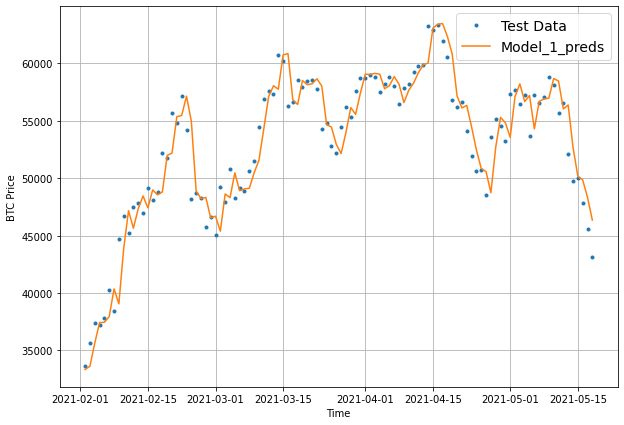

In [57]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [58]:
HORIZON = 1
WINDOW_SIZE = 30


In [60]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [61]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2205, 2205, 552, 552)

In [64]:
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_2_history = model_2.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_2_dense")])

In [65]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 826.9055 - mae: 826.9055 - mse: 1961867.6250


[826.905517578125, 826.905517578125, 1961867.625]

In [72]:
# Load in the best performing model and evaluate 
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 603.9243 - mae: 603.9243 - mse: 1258424.7500


[603.9242553710938, 603.9242553710938, 1258424.75]

In [73]:
# get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [74]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 603.92426,
 'mse': 1258424.6,
 'rmse': 1121.7953,
 'mape': 2.7289286,
 'mase': 1.0556654}

In [75]:
model_1_results

{'mae': 569.9069,
 'mse': 1172535.0,
 'rmse': 1082.8365,
 'mape': 2.5592942,
 'mase': 1.0011686}

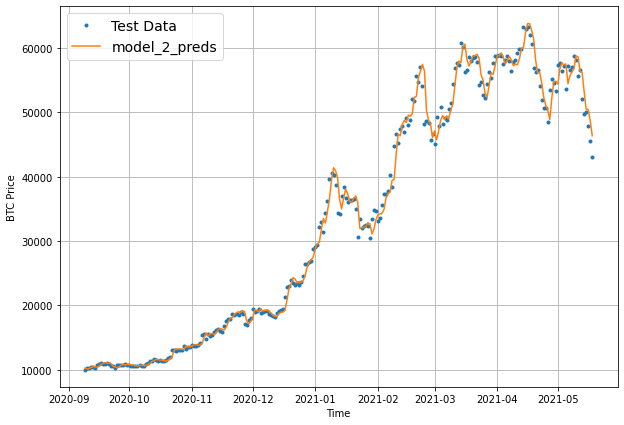

In [76]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)


In [77]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices,
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [78]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_labels,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

In [79]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_3_history = model_3.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_3_dense")])

Epoch 1/100
 1/18 [>.............................] - ETA: 19s - loss: 3146.8816 - mae: 3146.8816 - mse: 29490312.0000

18/18 [==============================] - 2s 46ms/step - loss: 2074.5752 - mae: 2074.5752 - mse: 14905154.0000 - val_loss: 7100.4185 - val_mae: 7100.4185 - val_mse: 168087904.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 1045.0427 - mae: 1045.0427 - mse: 5013499.0000

18/18 [==============================] - 1s 36ms/step - loss: 718.2632 - mae: 718.2632 - mse: 2721930.0000 - val_loss: 1911.9415 - val_mae: 1911.9415 - val_mse: 17610888.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 294.6559 - mae: 294.6559 - mse: 498127.8125

18/18 [==============================] - 1s 36ms/step - loss: 212.4536 - mae: 212.4536 - mse: 243016.3125 - val_loss: 997.9363 - val_mae: 997.9363 - val_mse: 2952597.2500
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 185.9896 - mae: 185.9896 - mse: 144846.3125

18/18 [==============================] - 1s 36ms/step - loss: 133.9339 - mae: 133.9339 - mse: 90113.8672 - val_loss: 635.9581 - val_mae: 635.9581 - val_mse: 1320937.8750
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 147.9946 - mae: 147.9946 - mse: 115966.0781

18/18 [==============================] - 1s 60ms/step - loss: 112.3212 - mae: 112.3212 - mse: 68980.2500 - val_loss: 595.1911 - val_mae: 595.1911 - val_mse: 1184911.7500
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 97.4374 - mae: 97.4374 - mse: 42591.2891

18/18 [==============================] - 1s 38ms/step - loss: 106.3013 - mae: 106.3013 - mse: 62315.7148 - val_loss: 549.4089 - val_mae: 549.4089 - val_mse: 1017650.4375
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 99.5970 - mae: 99.5970 - mse: 61943.0273

18/18 [==============================] - 1s 39ms/step - loss: 100.8831 - mae: 100.8831 - mse: 56661.1836 - val_loss: 534.5317 - val_mae: 534.5317 - val_mse: 941078.5000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 96.4114 - mae: 96.4114 - mse: 41580.5039

18/18 [==============================] - 1s 37ms/step - loss: 97.5519 - mae: 97.5519 - mse: 53163.2031 - val_loss: 525.7647 - val_mae: 525.7647 - val_mse: 904330.5000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 117.6904 - mae: 117.6904 - mse: 56958.8594

18/18 [==============================] - 1s 56ms/step - loss: 95.4381 - mae: 95.4381 - mse: 49859.0938 - val_loss: 490.5791 - val_mae: 490.5791 - val_mse: 802919.2500
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 90.5170 - mae: 90.5170 - mse: 44287.7734

18/18 [==============================] - 1s 63ms/step - loss: 90.6836 - mae: 90.6836 - mse: 45723.3672 - val_loss: 477.4565 - val_mae: 477.4565 - val_mse: 755636.8125
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 90.5097 - mae: 90.5097 - mse: 54508.0000

18/18 [==============================] - 1s 48ms/step - loss: 88.7252 - mae: 88.7252 - mse: 43591.4844 - val_loss: 453.5097 - val_mae: 453.5097 - val_mse: 681913.6250
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 84.3198 - mae: 84.3198 - mse: 39903.1055 - val_loss: 471.0647 - val_mae: 471.0647 - val_mse: 711707.0000
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 80.1522 - mae: 80.1522 - mse: 32399.6738

18/18 [==============================] - 1s 37ms/step - loss: 81.3893 - mae: 81.3893 - mse: 37397.3750 - val_loss: 422.9555 - val_mae: 422.9555 - val_mse: 587769.3750
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 79.4546 - mae: 79.4546 - mse: 28033.3613

18/18 [==============================] - 1s 37ms/step - loss: 76.9708 - mae: 76.9708 - mse: 33939.1836 - val_loss: 399.5770 - val_mae: 399.5770 - val_mse: 528519.2500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 75.4579 - mae: 75.4579 - mse: 29171.9062

18/18 [==============================] - 1s 37ms/step - loss: 73.8647 - mae: 73.8647 - mse: 31492.5820 - val_loss: 377.3602 - val_mae: 377.3602 - val_mse: 474742.6250
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 63.8014 - mae: 63.8014 - mse: 18084.1758

18/18 [==============================] - 1s 35ms/step - loss: 71.7745 - mae: 71.7745 - mse: 29850.5176 - val_loss: 363.4330 - val_mae: 363.4330 - val_mse: 448416.0312
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 81.8453 - mae: 81.8453 - mse: 49809.0547

18/18 [==============================] - 1s 36ms/step - loss: 68.7160 - mae: 68.7160 - mse: 27682.7246 - val_loss: 362.4814 - val_mae: 362.4814 - val_mse: 437349.3750
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 63.8810 - mae: 63.8810 - mse: 21209.7930

18/18 [==============================] - 1s 36ms/step - loss: 66.5302 - mae: 66.5302 - mse: 25826.6445 - val_loss: 337.0794 - val_mae: 337.0794 - val_mse: 385680.5625
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 64.5017 - mae: 64.5017 - mse: 23550.4512

18/18 [==============================] - 1s 36ms/step - loss: 64.3218 - mae: 64.3218 - mse: 24437.9199 - val_loss: 331.8745 - val_mae: 331.8745 - val_mse: 366865.5312
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 64.8305 - mae: 64.8305 - mse: 24752.3594

18/18 [==============================] - 1s 36ms/step - loss: 62.8047 - mae: 62.8047 - mse: 23386.4707 - val_loss: 321.9178 - val_mae: 321.9178 - val_mse: 350970.8125
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 61.2522 - mae: 61.2522 - mse: 22045.9980 - val_loss: 336.1548 - val_mae: 336.1548 - val_mse: 382209.8438
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 71.8439 - mae: 71.8439 - mse: 25681.3438

18/18 [==============================] - 1s 35ms/step - loss: 60.7357 - mae: 60.7357 - mse: 21555.2715 - val_loss: 320.2686 - val_mae: 320.2686 - val_mse: 331607.2812
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 65.7558 - mae: 65.7558 - mse: 30047.2246

18/18 [==============================] - 1s 57ms/step - loss: 59.9197 - mae: 59.9197 - mse: 20599.4629 - val_loss: 312.6279 - val_mae: 312.6279 - val_mse: 325109.5000
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 68.4336 - mae: 68.4336 - mse: 24663.4512

18/18 [==============================] - 1s 39ms/step - loss: 59.0607 - mae: 59.0607 - mse: 20078.6250 - val_loss: 293.2528 - val_mae: 293.2528 - val_mse: 289259.5625
Epoch 25/100
18/18 [==============================] - 0s 4ms/step - loss: 56.3106 - mae: 56.3106 - mse: 18430.8535 - val_loss: 305.0257 - val_mae: 305.0257 - val_mse: 303118.9062
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 55.6213 - mae: 55.6213 - mse: 17756.3223 - val_loss: 293.8445 - val_mae: 293.8445 - val_mse: 286217.6875
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 53.9078 - mae: 53.9078 - mse: 15437.8281

18/18 [==============================] - 1s 39ms/step - loss: 53.9513 - mae: 53.9513 - mse: 17217.7754 - val_loss: 282.1064 - val_mae: 282.1064 - val_mse: 262862.4375
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 53.1132 - mae: 53.1132 - mse: 16460.3125 - val_loss: 295.4037 - val_mae: 295.4037 - val_mse: 283739.3125
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 60.6432 - mae: 60.6432 - mse: 22881.2852

18/18 [==============================] - 1s 39ms/step - loss: 51.9237 - mae: 51.9237 - mse: 16053.9834 - val_loss: 275.6910 - val_mae: 275.6910 - val_mse: 247948.1094
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 51.5097 - mae: 51.5097 - mse: 15172.7451 - val_loss: 282.6424 - val_mae: 282.6424 - val_mse: 251475.5781
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 41.6341 - mae: 41.6341 - mse: 9670.3994

18/18 [==============================] - 1s 40ms/step - loss: 49.9799 - mae: 49.9799 - mse: 14372.6826 - val_loss: 265.0744 - val_mae: 265.0744 - val_mse: 230991.5781
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 51.2217 - mae: 51.2217 - mse: 12027.9932

18/18 [==============================] - 1s 57ms/step - loss: 49.0751 - mae: 49.0751 - mse: 14012.3701 - val_loss: 255.4722 - val_mae: 255.4722 - val_mse: 219116.0156
Epoch 33/100
17/18 [===========================>..] - ETA: 0s - loss: 48.1911 - mae: 48.1911 - mse: 13693.5107

18/18 [==============================] - 1s 60ms/step - loss: 47.9400 - mae: 47.9400 - mse: 13603.1416 - val_loss: 253.2759 - val_mae: 253.2759 - val_mse: 211818.9688
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 46.6666 - mae: 46.6666 - mse: 12678.2227

18/18 [==============================] - 1s 41ms/step - loss: 46.9256 - mae: 46.9256 - mse: 12758.0674 - val_loss: 252.6991 - val_mae: 252.6991 - val_mse: 205936.8125
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 41.7819 - mae: 41.7819 - mse: 8018.6777

18/18 [==============================] - 1s 37ms/step - loss: 45.4698 - mae: 45.4698 - mse: 12146.6289 - val_loss: 246.7719 - val_mae: 246.7719 - val_mse: 197961.3125
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 44.5250 - mae: 44.5250 - mse: 11679.5518 - val_loss: 276.5967 - val_mae: 276.5967 - val_mse: 232029.0156
Epoch 37/100
18/18 [==============================] - 0s 4ms/step - loss: 46.7060 - mae: 46.7060 - mse: 11819.7109 - val_loss: 261.9720 - val_mae: 261.9720 - val_mse: 209166.0156
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 47.3676 - mae: 47.3676 - mse: 11333.4648

18/18 [==============================] - 1s 37ms/step - loss: 43.8062 - mae: 43.8062 - mse: 11037.4932 - val_loss: 232.5051 - val_mae: 232.5051 - val_mse: 171478.9062
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 29.0535 - mae: 29.0535 - mse: 4946.4253

18/18 [==============================] - 1s 37ms/step - loss: 41.8721 - mae: 41.8721 - mse: 10247.0605 - val_loss: 223.1914 - val_mae: 223.1914 - val_mse: 159958.7188
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 29.7607 - mae: 29.7607 - mse: 4093.5073

18/18 [==============================] - 1s 37ms/step - loss: 40.4721 - mae: 40.4721 - mse: 9671.5410 - val_loss: 218.4362 - val_mae: 218.4362 - val_mse: 157198.2031
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 37.3172 - mae: 37.3172 - mse: 6562.4844

18/18 [==============================] - 1s 36ms/step - loss: 40.4222 - mae: 40.4222 - mse: 9436.6367 - val_loss: 209.4689 - val_mae: 209.4689 - val_mse: 142884.2031
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 38.8775 - mae: 38.8775 - mse: 8863.9385 - val_loss: 214.7237 - val_mae: 214.7237 - val_mse: 150800.2188
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 38.9320 - mae: 38.9320 - mse: 8826.2207 - val_loss: 223.0122 - val_mae: 223.0122 - val_mse: 151827.3906
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 40.0605 - mae: 40.0605 - mse: 8674.6953 - val_loss: 211.5277 - val_mae: 211.5277 - val_mse: 144034.9062
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 42.1940 - mae: 42.1940 - mse: 10538.1875

18/18 [==============================] - 1s 35ms/step - loss: 38.5971 - mae: 38.5971 - mse: 8181.3008 - val_loss: 194.2032 - val_mae: 194.2032 - val_mse: 126386.5234
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 36.0938 - mae: 36.0938 - mse: 7577.9404 - val_loss: 205.8520 - val_mae: 205.8520 - val_mse: 129491.8359
Epoch 47/100
 1/18 [>.............................] - ETA: 0s - loss: 33.8060 - mae: 33.8060 - mse: 6175.9307

18/18 [==============================] - 1s 37ms/step - loss: 35.6837 - mae: 35.6837 - mse: 7333.2642 - val_loss: 183.5819 - val_mae: 183.5819 - val_mse: 110385.2812
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 34.6240 - mae: 34.6240 - mse: 7024.2446 - val_loss: 187.1794 - val_mae: 187.1794 - val_mse: 123210.8047
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 34.9448 - mae: 34.9448 - mse: 7092.4453 - val_loss: 231.1401 - val_mae: 231.1401 - val_mse: 176653.9219
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 42.5431 - mae: 42.5431 - mse: 9903.4258

18/18 [==============================] - 1s 40ms/step - loss: 37.2484 - mae: 37.2484 - mse: 7757.7998 - val_loss: 177.6469 - val_mae: 177.6469 - val_mse: 102301.5469
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 34.6988 - mae: 34.6988 - mse: 6380.6445

18/18 [==============================] - 1s 38ms/step - loss: 33.5178 - mae: 33.5178 - mse: 6406.4600 - val_loss: 172.3289 - val_mae: 172.3289 - val_mse: 96937.4141
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 31.5670 - mae: 31.5670 - mse: 5889.7378 - val_loss: 181.7878 - val_mae: 181.7878 - val_mse: 101615.3750
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 35.3654 - mae: 35.3654 - mse: 6535.8823 - val_loss: 172.8501 - val_mae: 172.8501 - val_mse: 97605.7578
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 36.7243 - mae: 36.7243 - mse: 6170.4580

18/18 [==============================] - 1s 60ms/step - loss: 33.4551 - mae: 33.4551 - mse: 5930.7793 - val_loss: 171.6639 - val_mae: 171.6639 - val_mse: 97067.1016
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 37.0658 - mae: 37.0658 - mse: 5933.5190

18/18 [==============================] - 1s 37ms/step - loss: 31.1733 - mae: 31.1733 - mse: 5630.3633 - val_loss: 171.4915 - val_mae: 171.4915 - val_mse: 94628.0391
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 30.5483 - mae: 30.5483 - mse: 5222.9702 - val_loss: 181.9270 - val_mae: 181.9270 - val_mse: 98475.2812
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 32.5136 - mae: 32.5136 - mse: 4770.9561

18/18 [==============================] - 1s 37ms/step - loss: 29.8667 - mae: 29.8667 - mse: 4986.4229 - val_loss: 160.6020 - val_mae: 160.6020 - val_mse: 86800.5938
Epoch 58/100
 1/18 [>.............................] - ETA: 0s - loss: 28.8832 - mae: 28.8832 - mse: 5139.4209

18/18 [==============================] - 1s 45ms/step - loss: 28.6592 - mae: 28.6592 - mse: 4749.4883 - val_loss: 160.1854 - val_mae: 160.1854 - val_mse: 83018.6172
Epoch 59/100
18/18 [==============================] - ETA: 0s - loss: 28.2469 - mae: 28.2469 - mse: 4553.1572

18/18 [==============================] - 1s 57ms/step - loss: 28.2469 - mae: 28.2469 - mse: 4553.1572 - val_loss: 160.0468 - val_mae: 160.0468 - val_mse: 83558.2656
Epoch 60/100
18/18 [==============================] - ETA: 0s - loss: 27.6567 - mae: 27.6567 - mse: 4360.5000

18/18 [==============================] - 1s 58ms/step - loss: 27.6567 - mae: 27.6567 - mse: 4360.5000 - val_loss: 159.6303 - val_mae: 159.6303 - val_mse: 80212.1406
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 26.2867 - mae: 26.2867 - mse: 4068.8691 - val_loss: 163.8651 - val_mae: 163.8651 - val_mse: 82483.8047
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 28.3570 - mae: 28.3570 - mse: 4253.0522 - val_loss: 169.8698 - val_mae: 169.8698 - val_mse: 88837.4453
Epoch 63/100
 1/18 [>.............................] - ETA: 0s - loss: 32.4226 - mae: 32.4226 - mse: 6442.8555

18/18 [==============================] - 1s 37ms/step - loss: 28.3477 - mae: 28.3477 - mse: 4256.3311 - val_loss: 149.1936 - val_mae: 149.1936 - val_mse: 68628.0547
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 32.1778 - mae: 32.1778 - mse: 5486.3135

18/18 [==============================] - 1s 38ms/step - loss: 25.1665 - mae: 25.1665 - mse: 3662.1555 - val_loss: 133.0005 - val_mae: 133.0005 - val_mse: 57679.8594
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 25.2068 - mae: 25.2068 - mse: 3546.5955 - val_loss: 154.6075 - val_mae: 154.6075 - val_mse: 74676.3750
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 21.4525 - mae: 21.4525 - mse: 2546.9375

18/18 [==============================] - 1s 37ms/step - loss: 24.1891 - mae: 24.1891 - mse: 3369.1165 - val_loss: 128.4550 - val_mae: 128.4550 - val_mse: 56739.4414
Epoch 67/100
 1/18 [>.............................] - ETA: 0s - loss: 26.4969 - mae: 26.4969 - mse: 3109.1216

18/18 [==============================] - 1s 37ms/step - loss: 22.7485 - mae: 22.7485 - mse: 3136.7166 - val_loss: 120.3391 - val_mae: 120.3391 - val_mse: 47339.4844
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 21.6993 - mae: 21.6993 - mse: 2903.1045 - val_loss: 150.7059 - val_mae: 150.7059 - val_mse: 67197.7812
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 24.8466 - mae: 24.8466 - mse: 3221.6130 - val_loss: 136.5099 - val_mae: 136.5099 - val_mse: 60090.0469
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 23.3441 - mae: 23.3441 - mse: 3010.1724 - val_loss: 154.7918 - val_mae: 154.7918 - val_mse: 63052.2695
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 23.8421 - mae: 23.8421 - mse: 2871.9199 - val_loss: 161.5686 - val_mae: 161.5686 - val_mse: 68030.7812
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 32.2977 - mae: 32.2977 - mse: 5431.0068

18/18 [==============================] - 1s 37ms/step - loss: 23.4069 - mae: 23.4069 - mse: 2783.4788 - val_loss: 118.4458 - val_mae: 118.4458 - val_mse: 44281.0898
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 23.8723 - mae: 23.8723 - mse: 2780.6433 - val_loss: 165.0036 - val_mae: 165.0036 - val_mse: 70464.0156
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 26.2163 - mae: 26.2163 - mse: 3157.4954 - val_loss: 124.8399 - val_mae: 124.8399 - val_mse: 47150.6133
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 19.6057 - mae: 19.6057 - mse: 2132.5620 - val_loss: 153.3711 - val_mae: 153.3711 - val_mse: 63441.6250
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 25.1032 - mae: 25.1032 - mse: 2889.3564 - val_loss: 203.4496 - val_mae: 203.4496 - val_mse: 104192.6172
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 31.5440 - mae: 31.5440 - mse: 4542.6885 - val_loss: 

18/18 [==============================] - 1s 37ms/step - loss: 20.1110 - mae: 20.1110 - mse: 2045.0327 - val_loss: 110.1318 - val_mae: 110.1318 - val_mse: 34329.6914
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 18.5529 - mae: 18.5529 - mse: 1812.2358 - val_loss: 121.2583 - val_mae: 121.2583 - val_mse: 44803.0859
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 21.8538 - mae: 21.8538 - mse: 2334.8455

18/18 [==============================] - 1s 35ms/step - loss: 21.1741 - mae: 21.1741 - mse: 2278.1555 - val_loss: 109.2445 - val_mae: 109.2445 - val_mse: 39083.3867
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 18.9638 - mae: 18.9638 - mse: 1858.3289 - val_loss: 151.5178 - val_mae: 151.5178 - val_mse: 64322.8477
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 22.2696 - mae: 22.2696 - mse: 1856.0614

18/18 [==============================] - 1s 35ms/step - loss: 18.9558 - mae: 18.9558 - mse: 1766.5470 - val_loss: 101.4438 - val_mae: 101.4438 - val_mse: 29829.4883
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 18.1225 - mae: 18.1225 - mse: 1666.9293 - val_loss: 105.5212 - val_mae: 105.5212 - val_mse: 36340.2461
Epoch 84/100
 1/18 [>.............................] - ETA: 0s - loss: 21.1557 - mae: 21.1557 - mse: 2316.1177

18/18 [==============================] - 1s 37ms/step - loss: 17.0325 - mae: 17.0325 - mse: 1551.6281 - val_loss: 95.0941 - val_mae: 95.0941 - val_mse: 27745.5273
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 18.3552 - mae: 18.3552 - mse: 1601.2268 - val_loss: 98.3415 - val_mae: 98.3415 - val_mse: 28020.0762
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 18.0315 - mae: 18.0315 - mse: 1557.8939 - val_loss: 127.2953 - val_mae: 127.2953 - val_mse: 41209.0117
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 23.3724 - mae: 23.3724 - mse: 2415.5122

18/18 [==============================] - 1s 59ms/step - loss: 17.4220 - mae: 17.4220 - mse: 1500.2761 - val_loss: 89.4080 - val_mae: 89.4080 - val_mse: 31577.3867
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 18.9401 - mae: 18.9401 - mse: 1816.7423 - val_loss: 151.0289 - val_mae: 151.0289 - val_mse: 57241.2070
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 20.7605 - mae: 20.7605 - mse: 1872.2686 - val_loss: 184.2711 - val_mae: 184.2711 - val_mse: 84072.8906
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 24.9922 - mae: 24.9922 - mse: 2378.3420 - val_loss: 138.6633 - val_mae: 138.6633 - val_mse: 60270.7578
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 20.9510 - mae: 20.9510 - mse: 1933.9307 - val_loss: 99.0564 - val_mae: 99.0564 - val_mse: 30229.9668
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 18.2291 - mae: 18.2291 - mse: 1535.6311 - val_loss: 120.4

18/18 [==============================] - 1s 38ms/step - loss: 16.3531 - mae: 16.3531 - mse: 1165.6241 - val_loss: 87.4756 - val_mae: 87.4756 - val_mse: 19251.7383
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 17.8570 - mae: 17.8570 - mse: 1349.9993 - val_loss: 139.1391 - val_mae: 139.1391 - val_mse: 48124.8086
Epoch 99/100
18/18 [==============================] - 0s 4ms/step - loss: 15.4418 - mae: 15.4418 - mse: 990.4788 - val_loss: 112.7544 - val_mae: 112.7544 - val_mse: 32211.7207
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 14.3288 - mae: 14.3288 - mse: 897.0007 - val_loss: 93.1307 - val_mae: 93.1307 - val_mse: 23987.8594


In [80]:
# Evaluate model 3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 93.1307 - mae: 93.1307 - mse: 23987.8594


[93.13067626953125, 93.13067626953125, 23987.859375]

In [81]:
# Load best version of model_3
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 87.4756 - mae: 87.4756 - mse: 19251.7363


[87.47561645507812, 87.47561645507812, 19251.736328125]

In [82]:
# Make predictions 
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:3]

18/18 [==============================] - 1s 10ms/step


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[8761.414 , 8841.681 , 9037.295 , 8760.772 , 8726.961 , 8721.984 ,
        8593.731 ],
       [8760.771 , 9068.737 , 8750.524 , 8772.633 , 8725.097 , 8609.362 ,
        8446.251 ],
       [9028.8545, 8759.786 , 8791.573 , 8749.157 , 8627.723 , 8474.114 ,
        8406.122 ]], dtype=float32)>

In [83]:
# Evaluate model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': array([ 42.05999 ,  32.410713,  35.791992,  29.321987,  29.05071 ,
         33.262066,  35.340473,  32.736187,  29.655344,  35.39725 ,
         28.662598,  26.507185,  38.55064 ,  35.888603,  30.696707,
         36.64774 ,  34.160854,  38.36014 ,  30.728445,  31.635464,
         23.771902,  28.770786,  26.884487,  27.032854,  28.502651,
         28.769531,  26.106028,  25.024414,  26.941128,  25.182966,
         27.681223,  27.884487,  27.307129,  26.65862 ,  35.17027 ,
         26.100515,  37.95396 ,  55.483257,  44.025322,  29.066057,
         33.252373,  24.994768,  24.223145,  26.955915,  26.24986 ,
         24.786062,  26.47461 ,  28.037527,  25.919363,  25.112722,
         26.386858,  27.70438 ,  32.274136,  32.07889 ,  27.569265,
         27.413923,  31.839495,  32.035786,  24.069336,  35.30329 ,
         34.39858 ,  37.21519 ,  23.41769 ,  35.96847 ,  41.959126,
         32.244976,  34.848003,  33.53111 ,  32.78404 ,  34.19894 ,
         31.529018,  35.79297 ,  28.51939

## Make our evaluation function work for larger horizons


In [84]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [87]:
# Get model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': 87.47562,
 'mse': 19251.734,
 'rmse': 100.87801,
 'mape': 0.43268153,
 'mase': 0.15565796}

In [86]:
model_2_results

{'mae': 603.92426,
 'mse': 1258424.6,
 'rmse': 1121.7953,
 'mape': 2.7289286,
 'mase': 1.0556654}

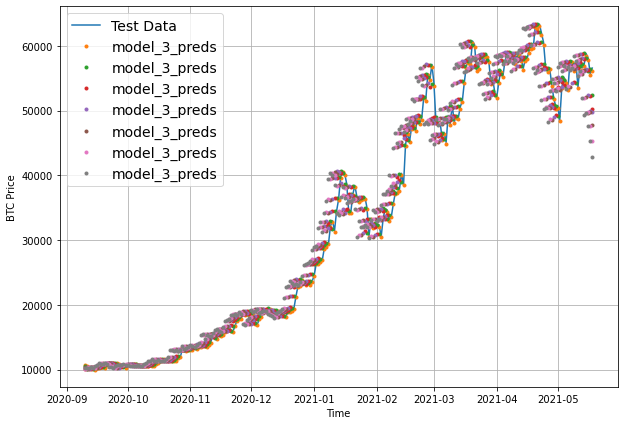

In [89]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

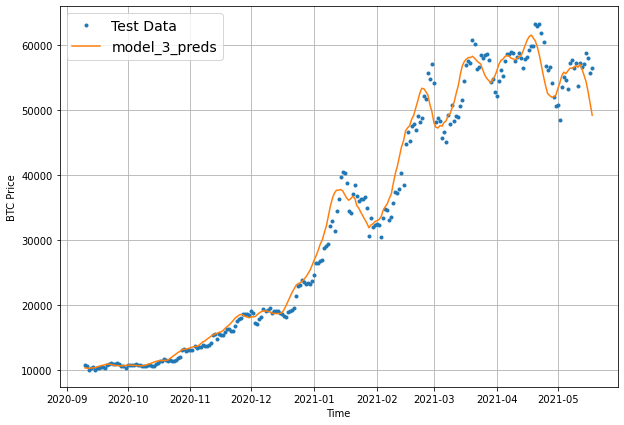

In [92]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")